## Semantic Segmentation - KITTI Dataset. 

This notebook is a tutorial for semantic segmentation. This is part of the project done at UMass Amherst. 

## Notes from CS231N
1. Semantic segmentation is about labelling every pixel. Semantic segmentation doesn't classify all the objects present in the image, like a semantic segmentation cannot identify the number of cows in the image. 

### Tutorial -> Fully Convolutional Networks for Semantic Segmentation

1. PASCAL VOC Dataset. Inference takes less than one fifth of a second for an image. Coarse to the fine inference to make a prediction at every pixel. 
2. Fully Convolutional network end to end. Inference and learning are performed whole image at a time by dense feedforward computation and back propagation. 
3. Semantic segmentation has two factors. Image wise semantics and the location of the pixels. Global information -> WHAT? whereas the local information -> Where. 
4. In-network upsampling and multi layer combinations. 
5. We re-architect and fine tune the classification nets to direct, dense prediction of semantic segmentation. 

#### Fully Convolutional Network
1. Locations in the higher layers correspond to the locations in the image they are path connected to -> which are called as "Receptive fields. "
2. Translation invariance. The fully connected layers can also be viewed as convolutions with kernels that cover their entire input region. 
3. The clssification nets sub sample to keep filters small and computational requirements reasonable. 


## How is semantic segmentation different from the traditional classification?
Semnatic segmentation does the classification pixel wise whereas the traditional classifiers does the classification image wise. 


## Todos
1. Check various datasets and select one dataset which you are willing to work upon. 
2. 

## Notes from the paper. 
1. We train with a per pixel multinomial logistic loss and validate it with the standard metric of mean pixel intersection over union with the mean value taken over all the classes, including the background. 
2. Decapitate each net by discarding the final classification layer and convert all fully connected layers into convolutions. 
3. Upsample the coarse outputs to the pixel dense outputs.. 
4. Atleast **175 epochs**

### Receptive fields
1. Locations in the higher layers correspond to the locations in the image they are path connected to, which are called their receptive fields. 
2. Conv nets are built on translational invariance. 
3. s -> Stride or the Sub sampling factor. 
4. For pixel wise prediction, we need to connect these coarse outputs back to the pixels. 
5. Deconvolution layers for upsampling. 
6. 


### Loss Function
1. The network is trained with per-pixel multinomial logistic loss. 
    1. The training ignores pixels that are masked out (as ambiguous or difficult) in the ground truth. 
2. The network is validated with the standard metric of mean pixel intersection over union, with the mean taken over all the classes, including the background. 


## Per pixel multinomial logistic function
1. This is similar to the logistic function and the cross entropy loss we have used before.

In [10]:
import os
import re
import cv2
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split


['/Users/gadde/desktop/SemanticSegmentation/iter1/VOCdevkit/VOC2012/JPEGImages/2007_000039.jpg', '/Users/gadde/desktop/SemanticSegmentation/iter1/VOCdevkit/VOC2012/SegmentationObject/2007_000039.png']
The image shape is:  (332, 500, 3)


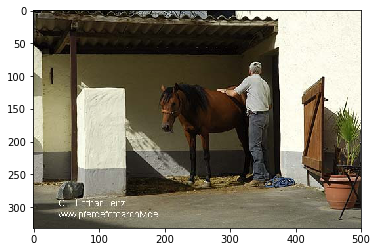

The image shape 2is:  (332, 500, 3)


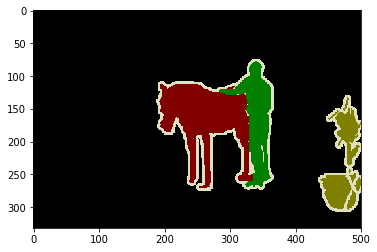

In [58]:
## Visualizing the data set and the ground truths. 
## The dataset has input images and output images and the output images has to be obtained from the input image. 

data_path = '/Users/gadde/desktop/SemanticSegmentation/iter1/VOCdevkit/VOC2012/ImageSets/Segmentation/'

imageFile = open(data_path+'train.txt')
images = []

source_data_path = '/Users/gadde/desktop/SemanticSegmentation/iter1/VOCdevkit/VOC2012/JPEGImages/'
label_data_path = '/Users/gadde/desktop/SemanticSegmentation/iter1/VOCdevkit/VOC2012/SegmentationObject/'

for line in imageFile:
    line_in_file = str(line)
    line_in_file = re.sub("\n","",line_in_file)
    
    source_image = source_data_path + str(line_in_file)+'.jpg'
    label_image = label_data_path + str(line_in_file) + '.png'
    
    images.append([source_image, label_image])


print (images[1])
image = mpimg.imread(images[40][0])
print ("The image shape is: ",image.shape)
plt.imshow(image)
plt.show()

image = mpimg.imread(images[40][1])
print ("The image shape 2is: ",image.shape)
plt.imshow(image)
plt.show()


## Train samples and the validation samples.
## Train samples ratio: 0.8
## Validation samples ration: 0.2

train_samples, val_samples = train_test_split( images, test_size = 0.2)
# print ("train samples 1 is: ",train_samples[0])

In [59]:
## Necessary Variables
batch_size = 32
num_epochs = 25


In [60]:
## Loading the VGG 16 weights:

def load_weights(weight_file, sess):
    weights_loaded = np.load(weight_file)
    keys = sorted(weights_loaded.keys())
    
    for i,k in enumerate(keys):
        if(i<26):
#             print (i,k, np.shape(weights_loaded[k]))
            sess.run(weights[k].assign(weights_loaded[k]))


In [61]:
## Defining Local Variables. 
## VGG 16 Weights and biases. 

weights = {
    'conv1_1_W': tf.Variable(tf.zeros([3,3,3,64], dtype = tf.float32), name = 'conv1_1_W', trainable = False),
    'conv1_2_W': tf.Variable(tf.zeros([3,3,64,64], dtype = tf.float32), name = 'conv1_2_W', trainable = False),
    'conv2_1_W': tf.Variable(tf.zeros([3,3,64,128], dtype = tf.float32), name = 'conv2_1_W', trainable = False),
    'conv2_2_W': tf.Variable(tf.zeros([3,3,128,128], dtype = tf.float32), name = 'conv2_2_W', trainable = False),
    'conv3_1_W': tf.Variable(tf.zeros([3,3,128,256], dtype = tf.float32), name = 'conv3_1_W', trainable = False),
    'conv3_2_W': tf.Variable(tf.zeros([3,3,256,256], dtype = tf.float32), name = 'conv3_2_W', trainable = False),
    'conv3_3_W': tf.Variable(tf.zeros([3,3,256,256], dtype = tf.float32), name = 'conv3_3_W', trainable = False),
    'conv4_1_W': tf.Variable(tf.zeros([3,3,256,512], dtype = tf.float32), name = 'conv4_1_W', trainable = False),
    'conv4_2_W': tf.Variable(tf.zeros([3,3,512,512], dtype = tf.float32), name = 'conv4_2_W', trainable = False),
    'conv4_3_W': tf.Variable(tf.zeros([3,3,512,512], dtype = tf.float32), name = 'conv4_3_W', trainable = False),
    'conv5_1_W': tf.Variable(tf.zeros([3,3,512,512], dtype = tf.float32), name = 'conv5_1_W', trainable = False),
    'conv5_2_W': tf.Variable(tf.zeros([3,3,512,512], dtype = tf.float32), name = 'conv5_2_W', trainable = False),
    'conv5_3_W': tf.Variable(tf.zeros([3,3,512,512], dtype = tf.float32), name = 'conv5_3_W', trainable = False),
    ## Biases below this.
    'conv1_1_b': tf.Variable(tf.zeros([64,], dtype = tf.float32), name = 'conv1_1_b', trainable = False),
    'conv1_2_b': tf.Variable(tf.zeros([64,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv2_1_b': tf.Variable(tf.zeros([128,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv2_2_b': tf.Variable(tf.zeros([128,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv3_1_b': tf.Variable(tf.zeros([256,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv3_2_b': tf.Variable(tf.zeros([256,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv3_3_b': tf.Variable(tf.zeros([256,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv4_1_b': tf.Variable(tf.zeros([512,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv4_2_b': tf.Variable(tf.zeros([512,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv4_3_b': tf.Variable(tf.zeros([512,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv5_1_b': tf.Variable(tf.zeros([512,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv5_2_b': tf.Variable(tf.zeros([512,], dtype = tf.float32), name = 'conv1_2_b', trainable = False),
    'conv5_3_b': tf.Variable(tf.zeros([512,], dtype = tf.float32), name = 'conv1_2_b', trainable = False)
}

new_weights = {
    'UpSampled_w1': tf.Variable(tf.truncated_normal([4, 4, 256 , 512], dtype = tf.float32, name = 'new_conv1')),
    'UpSampled_w2': tf.Variable(tf.truncated_normal([4, 4, 128, 256], dtype = tf.float32, name = 'new_conv2')),
    'UpSampled_w3': tf.Variable(tf.truncated_normal([4, 4, 64, 128], dtype = tf.float32, name = 'new_conv3')),
    'UpSampled_w4': tf.Variable(tf.truncated_normal([4, 4, 64, 64], dtype = tf.float32, name = 'new_conv4')),
    'UpSampled_w5': tf.Variable(tf.truncated_normal([4, 4, 64, 64], dtype = tf.float32, name = 'new_conv5')),
    'UpSampled_w6': tf.Variable(tf.truncated_normal([4,4,3,64], dtype = tf.float32, name = 'new_conv6'))
    }

new_biases = {
    'UpSampled_b1': tf.Variable(tf.truncated_normal([256], dtype = tf.float32, name = 'bias_1')),
    'UpSampled_b2': tf.Variable(tf.truncated_normal([128], dtype = tf.float32, name = 'bias_2')),
    'UpSampled_b3': tf.Variable(tf.truncated_normal([64], dtype = tf.float32, name = 'bias_3')),
    'UpSampled_b4': tf.Variable(tf.truncated_normal([64], dtype = tf.float32, name = 'bias_4')),
    'UpSampled_b5': tf.Variable(tf.truncated_normal([64], dtype = tf.float32, name = 'bias_5')),
    'UpSampled_b6': tf.Variable(tf.truncated_normal([3], dtype = tf.float32, name = 'bias_6'))
    }


In [62]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     load_weights('vgg16_weights.npz', sess)

In [63]:
def conv2d( x, W, b, strides =1):
    x = tf.nn.conv2d(x, W, strides = [1,strides,strides,1], padding = 'VALID')
    x = tf.nn.bias_add( x, b)
    return tf.nn.relu( x)
    
def conv2d_transpose( x, W, b, output_sh, strides =1 ):
    
    x = tf.nn.conv2d_transpose( x, W,output_shape=output_sh, strides = [1,strides,strides,1], padding = 'VALID')
    x = tf.nn.bias_add(x,b)
    return tf.nn.relu(x)
    
def maxpool2d( x, k=2 ):
    return tf.nn.max_pool( x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='VALID')

In [74]:
## Define the model here. 
# test_variable = tf.Variable(tf.zeros([ 32 , 11, 11, 256]))

def myModel(x):
    
    conv1_1 = conv2d( x, weights['conv1_1_W'], weights['conv1_1_b'],1)
    conv1_2 = conv2d( conv1_1, weights['conv1_2_W'], weights['conv1_2_b'],1)
    conv1_2 = maxpool2d( conv1_2, 2)
    
    conv2_1 = conv2d(conv1_2, weights['conv2_1_W'], weights['conv2_1_b'],1)
    conv2_2 = conv2d(conv2_1, weights['conv2_2_W'], weights['conv2_2_b'],1)
    conv2_2 = maxpool2d(conv2_1, 2)
    
    conv3_1 = conv2d( conv2_2, weights['conv3_1_W'], weights['conv3_1_b'],1)
    conv3_2 = conv2d(conv3_1, weights['conv3_2_W'], weights['conv3_2_b'],1)
    conv3_3 = conv2d(conv3_2, weights['conv3_3_W'], weights['conv3_3_b'],1)
    conv3_3 = maxpool2d(conv3_3, 2)
    conv4_1 = conv2d(conv3_3, weights['conv4_1_W'], weights['conv4_1_b'],1)    
    conv4_2 = conv2d(conv4_1, weights['conv4_2_W'], weights['conv4_2_b'],1)
    conv4_3 = conv2d(conv4_2, weights['conv4_3_W'], weights['conv4_3_b'],1)
    conv4_3 = maxpool2d(conv4_3, 2)
    conv5_1 = conv2d( conv4_3, weights['conv5_1_W'], weights['conv5_1_b'],1)
    conv5_2 = conv2d(conv5_1, weights['conv5_2_W'], weights['conv5_2_b'],1)
    conv5_3 = conv2d(conv5_2, weights['conv5_3_W'], weights['conv5_3_b'],1)
    conv5_3 = maxpool2d(conv5_3, 2)
    
    convUP1 = conv2d_transpose( conv5_3, new_weights['UpSampled_w1'], new_biases['UpSampled_b1'], output_sh = [batch_size,18,18,256], strides = 2)
    convUP2 = conv2d_transpose( convUP1, new_weights['UpSampled_w2'], new_biases['UpSampled_b2'], output_sh = [batch_size, 39, 39, 128], strides = 2)
    convUP3 = conv2d_transpose( convUP2, new_weights['UpSampled_w3'], new_biases['UpSampled_b3'], output_sh = [batch_size, 81, 81, 64], strides = 2)
    convUP4 = conv2d_transpose( convUP3, new_weights['UpSampled_w4'], new_biases['UpSampled_b4'], output_sh = [batch_size, 165, 165, 64], strides =2)
    convUP5 = conv2d_transpose( convUP4, new_weights['UpSampled_w5'], new_biases['UpSampled_b5'], output_sh = [batch_size, 333, 333, 64], strides =2)
    convUP6 = conv2d_transpose( convUP5, new_weights['UpSampled_w6'], new_biases['UpSampled_b6'], output_sh = [batch_size, 669, 669, 3], strides =2)
    
    fine_layer = convUP6
    fine_layer = tf.image.resize_images(fine_layer, [448,448])
    return fine_layer
    

In [76]:
def generator(train_samples, batch_size):
    
    num_samples = len(train_samples)
    
    while 1:
        
        sklearn.utils.shuffle(train_samples)
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = train_samples[offset:offset+batch_size]
            
            train_images = []
            label_images = []
            
            for batch_sample in batch_samples:
                
                image1 = cv2.imread(batch_sample[0])
                image1 = cv2.resize(image1, (448,448))
                
                image2 = cv2.imread(batch_sample[1])
                image2 = cv2.resize(image2, (448,448))
#                 print ("image2 shape is: ",image2.shape)
                train_images.append(image1)
                label_images.append(image2)
            
            train_images = np.array(train_images)
            label_images = np.array(label_images)
            
            yield train_images, label_images
            

In [77]:
def compute_loss(final_layer, ground_truth):
    
    ## Multinomial logistic loss function. 
    logits = tf.reshape(final_layer, (batch_size, -1))
    labels = tf.reshape(ground_truth, (batch_size, -1))
    logits = tf.nn.softmax(logits)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)
    loss = tf.reduce_sum(loss)
    return loss

In [78]:
## Define placeholders and the classifiers. 
## Change the image size here. 
input_image = tf.placeholder( tf.float32, shape = (None, 448,448,3), name = "input_image")
labels_image = tf.placeholder(tf.float32, shape = (None, 448, 448, 3), name = "labels_image")
image_pred = myModel(input_image)
print ("The image_pred shape is: ",image_pred.shape)

### Need to reshape the final layer here. 
lossFunction = compute_loss(image_pred, labels_image)
train_step = tf.train.AdamOptimizer(learning_rate = 1e-4)
trainingOperation = train_step.minimize(lossFunction)


The image_pred shape is:  (32, 448, 448, 3)


In [ ]:
## Define the Classifier. 
batch_size = 32
num_epochs = 25
saver = tf.train.Saver()
savefile = "models/model1.ckpt"

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    ## Need to load the weights here. 
    print ("Loading weights ")
    load_weights('vgg16_weights.npz',sess)
    print ("Loading weights done")
    
    ## Train the network
    for i in range(num_epochs):
        print ("Epoch Number: ",i)
        
        batch_generator = generator(train_samples, batch_size)
        
        for j in range(int(len(train_samples)/batch_size)):
            print ("j is: ",j)
            batchX, batchY = batch_generator.__next__()
            _ , training_loss = sess.run([trainingOperation, lossFunction], feed_dict = {input_image: batchX, labels_image: batchY})
            
#             if(j%10==0):
            print("The training loss is: ",training_loss)
                
        val_batch_generator = generator(val_samples, 100)
        valX, valY = val_batch_generator.__next__()
        val_loss = sess.run(trainingOperation, feed_dict = {input_image: batchX, labels_image: batchY})
        print ("The validation loss is : ",val_loss)
        
    saver.save(sess,savefile)
    

Loading weights 
Loading weights done
Epoch Number:  0
j is:  0
The training loss is:  5.96236e+09
j is:  1


In [ ]:
## Testing the result. 
## Visualizing the results. 


## We load the model here. 